# Understanding Freshman Satisfaction and Retention in Higher Education
- Madelyn Redick
- Sahana Dhar
- Shawn Lokshin

## Abstract
**summarizes the main results in a paragraph of no more than 6 sentences which is easily understood by laymen. Link to the graphs or sections later in the report which support each of the claims given in the abstract.**

This project investigates the qualities of universities that correspond to the amount of first year students that return for their second year. We obtained data from [The College Scorecard API](https://collegescorecard.ed.gov/data/documentation/) to collect various ifnormation from colleges in the United States.

TODO - main results

TODO - graphs or later sections

## Introduction

**a final, polished version of Project Proposal parts 1 and 3.**

TODO

## Understanding Freshman Satisfaction and Retention in Higher Education
### Madelyn Redick, Shawn Lokshin, Sahana Dhar

College and university life for students is an importance experience for many young adults nowadays. According to the Bureau of Labor Statistics, 61.8% of high school graduates were enrolled in college (2021). A significant issue that many institutions face is their impact on freshman satsifaction and the return rate of first year students. Colleges and unversities must continue adapting to the needs and expectations of the student bodies, in order to mintain enrollment rates. The questions we will be exploring in this projects are as follows:
1) What are the key determinants of freshman satisfaction within colleges, and how do they differ against institutions.
2) How do various institutional factors, such as tuition costs, diversity, academic calendar systems, on-campus housing availability, the number of undergraduates, and whether an institution is public or private, impact the likelihood of freshmen returning for their sophomore year? #TODO

These questions will include analyzing aspects of college life, such as the environment, diversity, facilities, and the student body, which ultimately impacts any students enjoyment of their college experience and their decision to continue their education there.


The collected data will be used for comprehensive data analysis, allowing us to understand the  elationship between various college factors and the key questions of interest: (1) understanding the determinants of freshman satisfaction, and (2) assessing the impact of institutional characteristics on the likelihood of freshmen returning for another year. By discovering correlations in factors, employing machine learning techniques, our analysis aims to provide colleges and universities with predictive insights that can guide colleges to enlist changes and techniques that will enhance the quality of the freshman experience and improve retention rates. 





## Data Description
**a final, polished version of Project Proposal part 2 as well as Data and Analysis Plan parts 2-4.**

TODO

TODO... add part 2 from from project proposal

### Pipeline Overview:
We webscrape from an [alphabetical list of colleges in the USA](https://www.4icu.org/us/a-z/) to create a list of names of colleges. 
We are using [The College Scorecard API](https://collegescorecard.ed.gov/data/documentation/) from the US Department of Education to obtain our data. This API allows us to get robust data for a specific school. For each school in the list of college names, we will filter desired data from the API into an organized dataframe. 

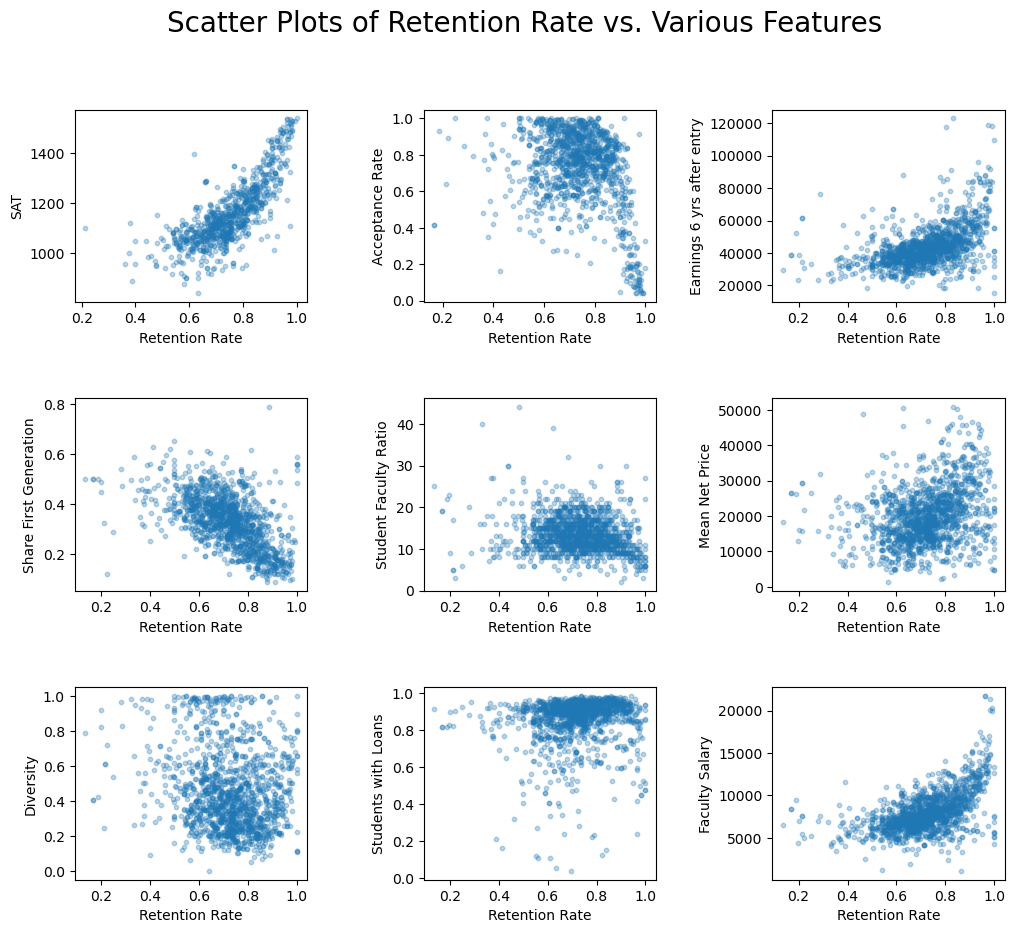

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
# convert csv to dataframe
df_colleges = pd.read_csv('college_data.csv')

# select numeric columns
columns = [item for item in df_colleges.columns if item not in ["Retention Rate", "College"]]

# create and format figure
plt.figure(figsize=(12, 10)) 
plt.suptitle("Scatter Plots of Retention Rate vs. Various Features", fontsize=20)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for idx, col in enumerate(columns):
    # activate specifc subplot
    plt.subplot(3, 3, idx+1)

    # plot scatter
    plt.scatter(df_colleges["Retention Rate"], df_colleges[col], s=10, alpha=0.3)
    plt.ylabel(col)
    plt.xlabel("Retention Rate")

## Method
The machine learning model we predict will be most fitting for our project is linear regression. We know that linear regression is used to predict a numeric variable y from various numeric variables x. Linear regression is important because it conveys R^2, the percentage of variance in y that can be explained by x. We may want to calculate R^2 and MSE using linear regression with predictors such as a college's admissions (SAT and acceptance rate), student body (size, diversity, student faculty ratio, and share first generation), and financials (mean tuition, mean net price, and earnings 6 years after entry) to see if we can predict the college's retention rate. We expect that some of these features will have an impact on the college's retention rate, though from the preliminary scatter plot analysis it is possible that admissions and financials are the most important features.  We will ensure that our numeric features are scaled before implementing machine learning, and will also make sure to cross validate, and if necessary, standardize while investigating different machine learning models.

We may also explore models such as decision trees and random forest, though we expect regression to be the most appropriate for our key questions. Additionally, we will consider feature selection techniques to maximize model accuracy and ensure the features elected are impactful.


**TODO...** 
- **Convince a technical expert that the method you chose is sound. Discuss any assumptions/pitfalls of the method and how they might impact the project.**
- **Educate an application expert on the broad outlines of the method you chose, providing a brief explanation of why this method is appropriate for the chosen problem.**

## Results

apply the ML method(s) of your choice, include:
- At least one graph of the results. Any graph should be explained in simple terms and easily interpretable on its own with appropriate labelling.
- Code and output which is clearly documented and implemented efficiently so as not to distract from the flow of the report.


TODO

## Discussion

**interpret your results in the application context. Determine if you found solutions to your questions of interest and explain why/why not. Critique your results; should they be accepted at face value or were some assumptions made inappropriate? What actions should be taken (if any) as a result of the analysis, and how confident are you in these actions? What questions that were unanticipated arose from the analysis, and what should future work/analyses focus on?**

TODO